# Descripción del Proyecto 

Rusty Bargain es un servicio de venta de coches de segunda mano que está desarrollando una app para atraer a nuevos clientes. Gracias a esa app, puedes averiguar rápidamente el valor de mercado de tu coche. Tienes acceso al historial, especificaciones técnicas, versiones de equipamiento y precios. Tienes que crear un modelo que determine el valor de mercado.

A Rusty Bargain le interesa:

- la calidad de la predicción
- la velocidad de la predicción
- el tiempo requerido para el entrenamiento

# Inicialización

In [1]:
#importemos las librerias que vamos a necesitar 
import pandas as pd 
import numpy as np 
from matplotlib import pyplot as plt 
import seaborn as sns 
from math import log10
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor 
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import mean_squared_error 
from catboost import CatBoostRegressor
import xgboost
import lightgbm as lgb
import time
from sklearn.metrics import r2_score


## Carga de datos 

In [2]:
#Importemos nuestros datos 
df = pd.read_csv('./car_data.csv')

## Análisis de datos 

In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 354369 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354369 non-null  object
 1   Price              354369 non-null  int64 
 2   VehicleType        316879 non-null  object
 3   RegistrationYear   354369 non-null  int64 
 4   Gearbox            334536 non-null  object
 5   Power              354369 non-null  int64 
 6   Model              334664 non-null  object
 7   Mileage            354369 non-null  int64 
 8   RegistrationMonth  354369 non-null  int64 
 9   FuelType           321474 non-null  object
 10  Brand              354369 non-null  object
 11  NotRepaired        283215 non-null  object
 12  DateCreated        354369 non-null  object
 13  NumberOfPictures   354369 non-null  int64 
 14  PostalCode         354369 non-null  int64 
 15  LastSeen           354369 non-null  object
dtypes: int64(7), object(

In [4]:
df.describe()

,Price,RegistrationYear,Power,Mileage,RegistrationMonth,NumberOfPictures,PostalCode
count,354369.000000,354369.000000,354369.000000,354369.000000,354369.000000,354369.0,354369.000000
mean,4416.656776,2004.234448,110.094337,128211.172535,5.714645,0.0,50508.689087
std,4514.158514,90.227958,189.850405,37905.341530,3.726421,0.0,25783.096248
min,0.000000,1000.000000,0.000000,5000.000000,0.000000,0.0,1067.000000
25%,1050.000000,1999.000000,69.000000,125000.000000,3.000000,0.0,30165.000000
50%,2700.000000,2003.000000,105.000000,150000.000000,6.000000,0.0,49413.000000
75%,6400.000000,2008.000000,143.000000,150000.000000,9.000000,0.0,71083.000000
max,20000.000000,9999.000000,20000.000000,150000.000000,12.000000,0.0,99998.000000


In [5]:
df.isna().sum()

DateCrawled              0
Price                    0
VehicleType          37490
RegistrationYear         0
Gearbox              19833
Power                    0
Model                19705
Mileage                  0
RegistrationMonth        0
FuelType             32895
Brand                    0
NotRepaired          71154
DateCreated              0
NumberOfPictures         0
PostalCode               0
LastSeen                 0
dtype: int64

In [6]:
df.isna().sum()/354369 *100

DateCrawled           0.000000
Price                 0.000000
VehicleType          10.579368
RegistrationYear      0.000000
Gearbox               5.596709
Power                 0.000000
Model                 5.560588
Mileage               0.000000
RegistrationMonth     0.000000
FuelType              9.282697
Brand                 0.000000
NotRepaired          20.079070
DateCreated           0.000000
NumberOfPictures      0.000000
PostalCode            0.000000
LastSeen              0.000000
dtype: float64

In [7]:
df.duplicated().sum()

np.int64(262)

In [8]:
df.sample(10)

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
278140,21/03/2016 12:40,12500,suv,2004,auto,218,x_reihe,150000,12,gasoline,bmw,no,21/03/2016 00:00,0,77933,06/04/2016 06:45
230095,09/03/2016 16:52,11500,convertible,1929,manual,15,other,5000,1,petrol,bmw,yes,09/03/2016 00:00,0,70569,07/04/2016 06:44
120794,19/03/2016 12:43,150,small,2002,manual,40,seicento,100000,3,petrol,fiat,yes,19/03/2016 00:00,0,29459,21/03/2016 16:48
22990,28/03/2016 12:42,950,sedan,1998,manual,55,golf,150000,10,NaN,volkswagen,yes,28/03/2016 00:00,0,48599,04/04/2016 13:47
85951,28/03/2016 20:44,1200,convertible,1996,manual,121,3_reihe,125000,9,petrol,peugeot,no,28/03/2016 00:00,0,85748,01/04/2016 06:15
89434,26/03/2016 10:36,950,small,1999,manual,54,corsa,150000,7,petrol,opel,no,26/03/2016 00:00,0,49074,05/04/2016 21:17
22771,25/03/2016 11:56,300,convertible,1997,manual,115,other,150000,0,petrol,audi,yes,25/03/2016 00:00,0,63755,25/03/2016 11:56
168822,16/03/2016 23:37,2800,sedan,2001,manual,149,NaN,150000,12,NaN,bmw,no,16/03/2016 00:00,0,48324,19/03/2016 06:18
16454,17/03/2016 17:50,2400,small,2005,manual,80,corsa,100000,6,petrol,opel,no,17/03/2016 00:00,0,45665,17/03/2016 17:50
8019,23/03/2016 00:55,3199,sedan,2001,manual,101,golf,150000,9,gasoline,volkswagen,no,22/03/2016 00:00,0,51465,28/03/2016 22:46


In [9]:
df['RegistrationMonth'].value_counts(normalize=True).sort_index()

RegistrationMonth
0     0.105404
1     0.065522
2     0.060014
3     0.096998
4     0.082598
5     0.082267
6     0.088913
7     0.076793
8     0.063852
9     0.067198
10    0.073649
11    0.068251
12    0.068542
Name: proportion, dtype: float64

In [10]:
df['Power'].value_counts(normalize=True).sort_index()

Power
0        0.113512
1        0.000096
2        0.000028
3        0.000025
4        0.000085
           ...   
17932    0.000003
19208    0.000003
19211    0.000003
19312    0.000003
20000    0.000003
Name: proportion, Length: 712, dtype: float64

In [11]:
df[df['Power'] == 20000]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
219584,09/03/2016 15:43,4300,coupe,1999,auto,20000,clk,150000,1,petrol,mercedes_benz,no,09/03/2016 00:00,0,19406,30/03/2016 08:47


In [12]:
df[df['Power'] > 600]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
1816,22/03/2016 20:52,3200,small,2004,manual,1398,corolla,5000,6,petrol,toyota,no,22/03/2016 00:00,0,22043,22/03/2016 21:43
2102,21/03/2016 11:55,0,sedan,1999,NaN,1799,vectra,150000,1,petrol,opel,yes,21/03/2016 00:00,0,1723,04/04/2016 04:49
3746,21/03/2016 14:48,0,NaN,2017,manual,750,NaN,150000,8,petrol,smart,no,21/03/2016 00:00,0,49356,24/03/2016 03:44
4060,03/04/2016 20:31,3100,sedan,2005,manual,953,colt,150000,4,gasoline,mitsubishi,no,03/04/2016 00:00,0,60326,07/04/2016 14:56
5328,29/03/2016 19:44,500,wagon,1999,manual,1001,astra,150000,7,petrol,opel,NaN,29/03/2016 00:00,0,33154,06/04/2016 05:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
348968,04/04/2016 18:53,250,small,1999,manual,1241,ypsilon,150000,5,petrol,lancia,yes,04/04/2016 00:00,0,28259,04/04/2016 18:53
351947,07/03/2016 21:36,1500,bus,2001,manual,1001,zafira,5000,7,gasoline,opel,no,07/03/2016 00:00,0,66117,09/03/2016 12:47
353493,02/04/2016 20:54,12500,NaN,2017,manual,2000,other,60000,0,gasoline,chrysler,no,02/04/2016 00:00,0,44145,06/04/2016 21:44
353633,23/03/2016 23:55,2400,sedan,2007,manual,650,c2,150000,8,petrol,citroen,NaN,23/03/2016 00:00,0,45277,27/03/2016 01:15


In [13]:
df[df['Power'] < 60]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
0,24/03/2016 11:52,480,NaN,1993,manual,0,golf,150000,0,petrol,volkswagen,NaN,24/03/2016 00:00,0,70435,07/04/2016 03:16
7,21/03/2016 18:54,0,sedan,1980,manual,50,other,40000,7,petrol,volkswagen,no,21/03/2016 00:00,0,19348,25/03/2016 16:47
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,0,24148,19/03/2016 08:46
23,12/03/2016 19:43,450,small,1997,manual,50,arosa,150000,5,petrol,seat,no,12/03/2016 00:00,0,9526,21/03/2016 01:46
28,09/03/2016 11:56,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,09/03/2016 00:00,0,87471,10/03/2016 07:44
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
354358,04/04/2016 09:57,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,04/04/2016 00:00,0,48653,06/04/2016 11:17
354360,02/04/2016 20:37,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,02/04/2016 00:00,0,81825,06/04/2016 20:47
354363,27/03/2016 20:36,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,27/03/2016 00:00,0,26624,29/03/2016 10:17
354364,21/03/2016 09:50,0,NaN,2005,manual,0,colt,150000,7,petrol,mitsubishi,yes,21/03/2016 00:00,0,2694,21/03/2016 10:42


In [14]:
df[(((df['Power'] < 60) & (df['RegistrationYear'] < 1950)))]

,DateCrawled,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,DateCreated,NumberOfPictures,PostalCode,LastSeen
15,11/03/2016 21:39,450,small,1910,NaN,0,ka,5000,0,petrol,ford,NaN,11/03/2016 00:00,0,24148,19/03/2016 08:46
622,16/03/2016 16:55,0,NaN,1111,NaN,0,NaN,5000,0,NaN,opel,NaN,16/03/2016 00:00,0,44628,20/03/2016 16:44
1928,25/03/2016 15:58,7000,suv,1945,manual,48,other,150000,2,petrol,volkswagen,no,25/03/2016 00:00,0,58135,25/03/2016 15:58
2273,15/03/2016 21:44,1800,convertible,1925,NaN,0,NaN,5000,1,NaN,sonstige_autos,no,15/03/2016 00:00,0,79288,07/04/2016 05:15
6629,02/04/2016 13:47,0,small,1910,NaN,0,NaN,5000,1,other,sonstige_autos,NaN,02/04/2016 00:00,0,93105,04/04/2016 11:16
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
336104,11/03/2016 11:51,20000,coupe,1929,manual,12,other,10000,4,petrol,bmw,NaN,11/03/2016 00:00,0,74523,07/04/2016 05:45
343083,01/04/2016 08:51,1,other,1910,NaN,0,NaN,5000,1,other,volkswagen,NaN,01/04/2016 00:00,0,18273,07/04/2016 05:44
351682,12/03/2016 00:57,11500,NaN,1800,NaN,16,other,5000,6,petrol,fiat,NaN,11/03/2016 00:00,0,16515,05/04/2016 19:47
353531,16/03/2016 21:56,6000,sedan,1937,manual,38,other,5000,0,petrol,mercedes_benz,NaN,16/03/2016 00:00,0,23936,30/03/2016 18:47


<Axes: xlabel='Power', ylabel='Price'>

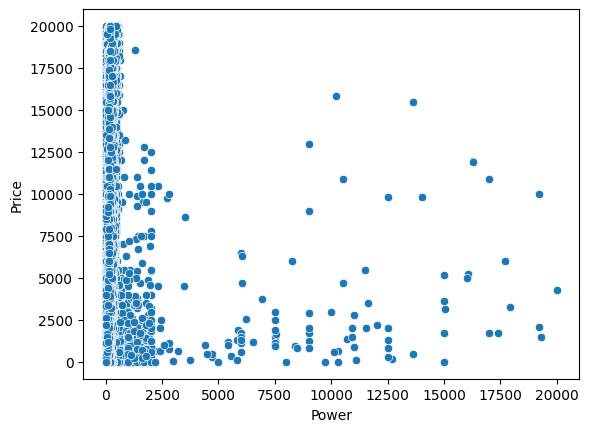

In [15]:
sns.scatterplot(df, x='Power', y='Price')

In [16]:
df['Brand'].value_counts(normalize=True).sort_index()

Brand
alfa_romeo        0.006530
audi              0.083122
bmw               0.104168
chevrolet         0.004950
chrysler          0.004061
citroen           0.014527
dacia             0.002540
daewoo            0.001529
daihatsu          0.002274
fiat              0.027212
ford              0.071053
honda             0.007949
hyundai           0.010122
jaguar            0.001425
jeep              0.001910
kia               0.006956
lada              0.000635
lancia            0.001329
land_rover        0.001538
mazda             0.015845
mercedes_benz     0.090431
mini              0.009036
mitsubishi        0.008528
nissan            0.013943
opel              0.112682
peugeot           0.031035
porsche           0.002139
renault           0.050589
rover             0.001371
saab              0.001484
seat              0.019491
skoda             0.015521
smart             0.014804
sonstige_autos    0.009521
subaru            0.002150
suzuki            0.006555
toyota            0.01

In [17]:
#Que tipo de combustible usan
df['FuelType'].value_counts(normalize=True)

FuelType
petrol      0.673000
gasoline    0.307085
lpg         0.016518
cng         0.001758
hybrid      0.000725
other       0.000635
electric    0.000280
Name: proportion, dtype: float64

<Axes: xlabel='FuelType', ylabel='Price'>

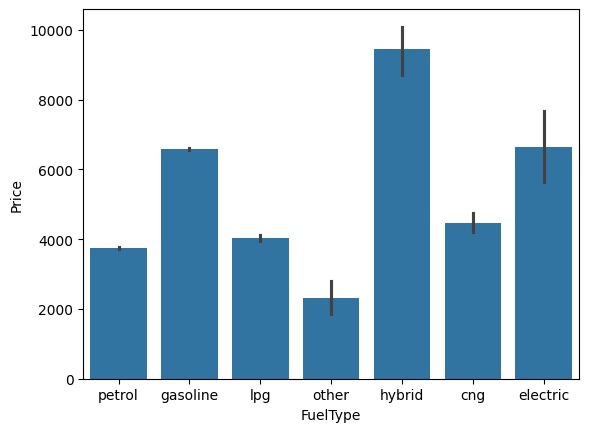

In [18]:
sns.barplot(df, x='FuelType', y='Price')

In [19]:
df['VehicleType'].value_counts(normalize=True)

VehicleType
sedan          0.288618
small          0.251929
wagon          0.205649
bus            0.090808
convertible    0.063756
coupe          0.051007
suv            0.037857
other          0.010376
Name: proportion, dtype: float64

<Axes: xlabel='VehicleType', ylabel='Price'>

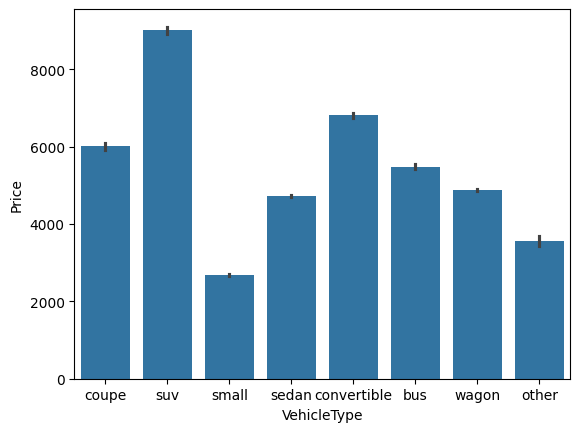

In [20]:
sns.barplot(df, x='VehicleType', y='Price')

In [21]:
df['Gearbox'].value_counts(normalize=True)

Gearbox
manual    0.80186
auto      0.19814
Name: proportion, dtype: float64

In [22]:
0.801832 / 0.198168

4.046223406402648

<Axes: xlabel='Gearbox', ylabel='Price'>

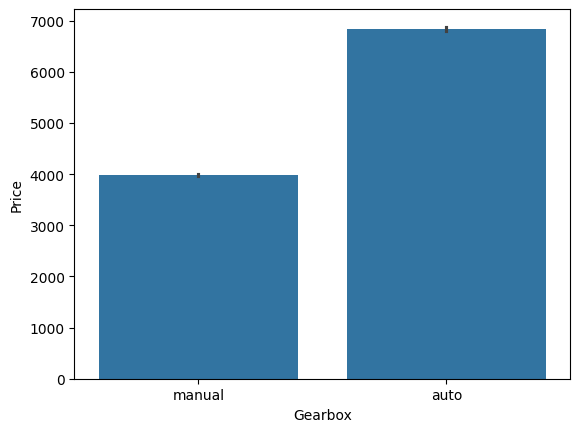

In [23]:
sns.barplot(df, x='Gearbox', y='Price')

In [24]:
df['NotRepaired'].value_counts(normalize=True)

NotRepaired
no     0.872697
yes    0.127303
Name: proportion, dtype: float64

In [25]:
0.872651 / 0.127349

6.852437003824137

<Axes: xlabel='NotRepaired', ylabel='Price'>

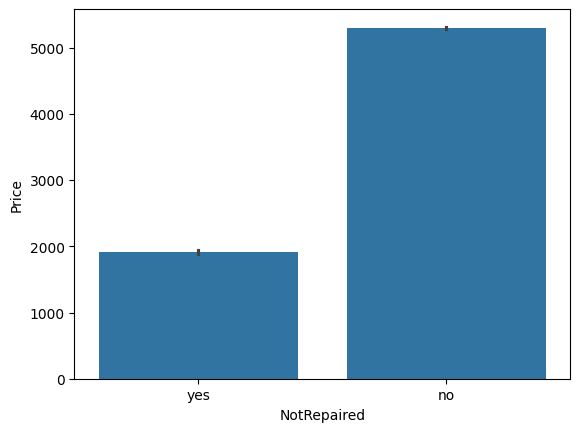

In [26]:
sns.barplot(df, x='NotRepaired', y='Price')

In [27]:
df[['Price','Mileage','RegistrationYear','Power','RegistrationMonth','NumberOfPictures','PostalCode']].corr()

,Price,Mileage,RegistrationYear,Power,RegistrationMonth,NumberOfPictures,PostalCode
Price,1.000000,-0.333199,0.026916,0.158872,0.110581,NaN,0.076055
Mileage,-0.333199,1.000000,-0.053447,0.024002,0.009571,NaN,-0.007698
RegistrationYear,0.026916,-0.053447,1.000000,-0.000828,-0.011619,NaN,-0.003459
Power,0.158872,0.024002,-0.000828,1.000000,0.043380,NaN,0.021665
RegistrationMonth,0.110581,0.009571,-0.011619,0.043380,1.000000,NaN,0.013995
NumberOfPictures,NaN,NaN,NaN,NaN,NaN,NaN,NaN
PostalCode,0.076055,-0.007698,-0.003459,0.021665,0.013995,NaN,1.000000


[None, None, None, None, None, None, None]

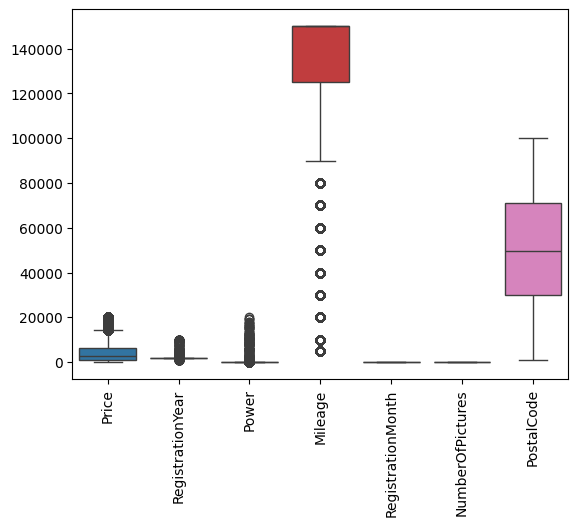

In [28]:
#Veamos la distribución de nuestro dataset 
plot=sns.boxplot(data=df)
plt.setp(plot.get_xticklabels(), rotation=90)

In [29]:
#Analisemos nuestra variable objetivo 

X = df.drop(columns={'DateCrawled','DateCreated','LastSeen','NumberOfPictures'})
Y = df['Price']

In [30]:
Y.describe()

count    354369.000000
mean       4416.656776
std        4514.158514
min           0.000000
25%        1050.000000
50%        2700.000000
75%        6400.000000
max       20000.000000
Name: Price, dtype: float64

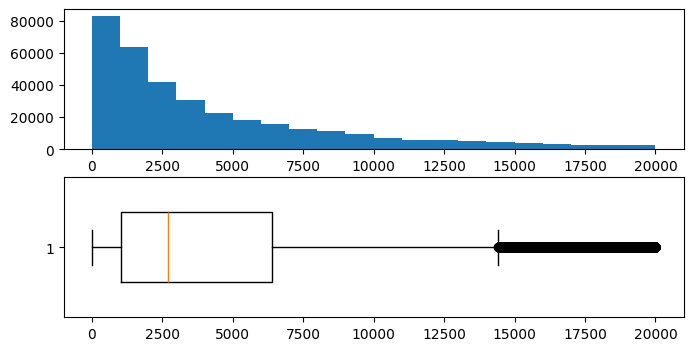

In [31]:
#Ahora veamos solo de nuestro objetivo 
fig, ax = plt.subplots(2,1, figsize = [8,4])
ax[0].hist(Y, bins = 20)
ax[1].boxplot(Y,vert=False , widths = 0.5)
plt.show()

In [32]:
#Revisemos el periodo de años de los registros
df['RegistrationYear'].value_counts().sort_index(ascending=True)

RegistrationYear
1000    37
1001     1
1039     1
1111     3
1200     1
        ..
9000     3
9229     1
9450     1
9996     1
9999    26
Name: count, Length: 151, dtype: int64

In [33]:
df['RegistrationYear'].describe()

count    354369.000000
mean       2004.234448
std          90.227958
min        1000.000000
25%        1999.000000
50%        2003.000000
75%        2008.000000
max        9999.000000
Name: RegistrationYear, dtype: float64

In [34]:
#Veamos si hay precios que sean 0  y/o muy bajos 
print(df['Price'].value_counts().sort_index(ascending=True))

Price
0        10772
1         1189
2           12
3            8
4            1
         ...  
19995       10
19997        1
19998        6
19999      278
20000      268
Name: count, Length: 3731, dtype: int64


In [35]:
#Cuantos vehiculos hay con valor menor a 500 
print((df['Price'] < 500).sum())

36054


In [36]:
#Cuantos vehiculos hay en rango de años de 1940 a 2022 
range_period = df[((df['RegistrationYear'] > 1939) & (df['RegistrationYear'] < 2023))]
range_period.info()

<class 'pandas.core.frame.DataFrame'>
Index: 354042 entries, 0 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        354042 non-null  object
 1   Price              354042 non-null  int64 
 2   VehicleType        316796 non-null  object
 3   RegistrationYear   354042 non-null  int64 
 4   Gearbox            334438 non-null  object
 5   Power              354042 non-null  int64 
 6   Model              334493 non-null  object
 7   Mileage            354042 non-null  int64 
 8   RegistrationMonth  354042 non-null  int64 
 9   FuelType           321361 non-null  object
 10  Brand              354042 non-null  object
 11  NotRepaired        283147 non-null  object
 12  DateCreated        354042 non-null  object
 13  NumberOfPictures   354042 non-null  int64 
 14  PostalCode         354042 non-null  int64 
 15  LastSeen           354042 non-null  object
dtypes: int64(7), object(9)
me

In [37]:
#Cuantos vehiculos dentro de 1940 a 2022 tienen precio mayor que 500
price_not_0_year_range= df[((df['Price'] >= 500) & ((df['RegistrationYear'] > 1939) & (df['RegistrationYear'] < 2023)))]
print(price_not_0_year_range.info())

<class 'pandas.core.frame.DataFrame'>
Index: 318172 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        318172 non-null  object
 1   Price              318172 non-null  int64 
 2   VehicleType        291170 non-null  object
 3   RegistrationYear   318172 non-null  int64 
 4   Gearbox            304899 non-null  object
 5   Power              318172 non-null  int64 
 6   Model              303550 non-null  object
 7   Mileage            318172 non-null  int64 
 8   RegistrationMonth  318172 non-null  int64 
 9   FuelType           294928 non-null  object
 10  Brand              318172 non-null  object
 11  NotRepaired        263676 non-null  object
 12  DateCreated        318172 non-null  object
 13  NumberOfPictures   318172 non-null  int64 
 14  PostalCode         318172 non-null  int64 
 15  LastSeen           318172 non-null  object
dtypes: int64(7), object(9)
me

In [38]:
#cuales son los años de registro de los vehiculos con precio mayor que 500 y el rango de 1949 a 2022 
print(price_not_0_year_range['RegistrationYear'].value_counts().sort_index(ascending=True))

RegistrationYear
1940       2
1941       2
1942       2
1943       4
1944       2
        ... 
2015    1057
2016    6893
2017    9237
2018    3735
2019      13
Name: count, Length: 80, dtype: int64


In [39]:
#Cuantos valores estariamos quitando del DT si decidimos dejar este rango
drop_range = df[(((df['Price'] < 500)) & ((df['RegistrationYear'] > 1939) & (df['RegistrationYear'] < 2023)))]
print(drop_range.info())

<class 'pandas.core.frame.DataFrame'>
Index: 35870 entries, 0 to 354364
Data columns (total 16 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   DateCrawled        35870 non-null  object
 1   Price              35870 non-null  int64 
 2   VehicleType        25626 non-null  object
 3   RegistrationYear   35870 non-null  int64 
 4   Gearbox            29539 non-null  object
 5   Power              35870 non-null  int64 
 6   Model              30943 non-null  object
 7   Mileage            35870 non-null  int64 
 8   RegistrationMonth  35870 non-null  int64 
 9   FuelType           26433 non-null  object
 10  Brand              35870 non-null  object
 11  NotRepaired        19471 non-null  object
 12  DateCreated        35870 non-null  object
 13  NumberOfPictures   35870 non-null  int64 
 14  PostalCode         35870 non-null  int64 
 15  LastSeen           35870 non-null  object
dtypes: int64(7), object(9)
memory usage: 4.7+ MB

In [40]:
#Revisemos todos nuestros tipos de vehiculos dentro del rango que vamos a usar de 1900 a 2022 y precio mayor que 0 
price_not_0_year_range['VehicleType'].value_counts()

VehicleType
sedan          85456
small          68280
wagon          60739
bus            27834
convertible    19539
coupe          14841
suv            11715
other           2766
Name: count, dtype: int64

Encontramos que el dataset contiene valores nulos y filas duplicadas. Tenemos varias columnas con fechas pero que son tipo objeto que no nos van a ayudar a predecir el precio ... También observamos una distribución anormal para nuestro objetivo (sesgados a la derecha). Hay 35870 vehiculos con precios menores a 500 e incluso 0 en un rango de año de 1940 a 2022, adicional los años de registro de los vehiculos van desde el año 1000 al 9999 por lo que no podemos tener en cuenta ese tipo de valores anormales.  

## Preparar y corregir datos 

In [41]:
#Vamos a eliminar los valores con precio menor a 300 y consideraremos el rango de 1940 a 2022 como el definitivo para nuestro analisis y modelaje. 
new_df = df[((df['Price'] >= 500) & ((df['RegistrationYear'] > 1939) & (df['RegistrationYear'] < 2023)))]
new_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 318172 entries, 1 to 354368
Data columns (total 16 columns):
 #   Column             Non-Null Count   Dtype 
---  ------             --------------   ----- 
 0   DateCrawled        318172 non-null  object
 1   Price              318172 non-null  int64 
 2   VehicleType        291170 non-null  object
 3   RegistrationYear   318172 non-null  int64 
 4   Gearbox            304899 non-null  object
 5   Power              318172 non-null  int64 
 6   Model              303550 non-null  object
 7   Mileage            318172 non-null  int64 
 8   RegistrationMonth  318172 non-null  int64 
 9   FuelType           294928 non-null  object
 10  Brand              318172 non-null  object
 11  NotRepaired        263676 non-null  object
 12  DateCreated        318172 non-null  object
 13  NumberOfPictures   318172 non-null  int64 
 14  PostalCode         318172 non-null  int64 
 15  LastSeen           318172 non-null  object
dtypes: int64(7), object(9)
me

In [42]:
new_df.duplicated().sum()

np.int64(254)

In [43]:
36197/ 354369 * 100

10.214493931466917

In [44]:
#Vemos que existen aún valores duplicados, los eliminamos y validamos. 
new_df.drop_duplicates(inplace=True)
new_df.duplicated().sum()

/var/folders/5p/2k4j0bp9765brxsy2bdmtt6w0000gn/T/ipykernel_78421/856879779.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  new_df.drop_duplicates(inplace=True)


np.int64(0)

In [45]:
#Eliminamos las columnas que sabemos que no nos van a servir
new_df = new_df.drop(columns={'DateCrawled','DateCreated','LastSeen','NumberOfPictures'})
new_df.columns

Index(['Price', 'VehicleType', 'RegistrationYear', 'Gearbox', 'Power', 'Model',
       'Mileage', 'RegistrationMonth', 'FuelType', 'Brand', 'NotRepaired',
       'PostalCode'],
      dtype='object')

In [46]:
#Dejemos solo los valores donde power sea menor que 600 
new_df = new_df[new_df['Power'] < 800]
new_df

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
1,18300,coupe,2011,manual,190,NaN,125000,5,gasoline,audi,yes,66954
2,9800,suv,2004,auto,163,grand,125000,8,gasoline,jeep,NaN,90480
3,1500,small,2001,manual,75,golf,150000,6,petrol,volkswagen,no,91074
4,3600,small,2008,manual,69,fabia,90000,7,gasoline,skoda,no,60437
5,650,sedan,1995,manual,102,3er,150000,10,petrol,bmw,yes,33775
...,...,...,...,...,...,...,...,...,...,...,...,...
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624
354365,2200,NaN,2005,NaN,0,NaN,20000,1,NaN,sonstige_autos,NaN,39576
354366,1199,convertible,2000,auto,101,fortwo,125000,3,petrol,smart,no,26135
354367,9200,bus,1996,manual,102,transporter,150000,3,gasoline,volkswagen,no,87439


In [47]:
#Veamos cuantos valores son menores de 60 de power después de la modificación al DT
new_df[new_df['Power'] < 60]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
28,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,87471
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,46483
52,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,34454
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,88433
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,56759
...,...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,18246
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,48653
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,81825
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624


In [48]:
#Aplicamos un mask para cambiar los valores menos de 60 de CV y menores de 1950 por el CV = 60
new_df['Power'] = new_df['Power'].mask(((new_df['Power'] < 60) & (new_df['RegistrationYear'] < 1950)), other=60) 

In [49]:
#Validamos que hayan quedado modificados 
new_df[(new_df['RegistrationYear'] < 1950)]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
1928,7000,suv,1945,manual,60,other,150000,2,petrol,volkswagen,no,58135
16635,9500,suv,1941,manual,60,NaN,40000,1,petrol,sonstige_autos,no,59557
26216,15000,small,1940,manual,60,NaN,5000,7,petrol,sonstige_autos,no,4924
27525,13300,sedan,1949,NaN,99,other,60000,7,petrol,chrysler,NaN,28279
29933,12900,sedan,1940,manual,60,NaN,150000,4,petrol,ford,NaN,45657
63186,17500,wagon,1948,manual,60,NaN,60000,6,petrol,sonstige_autos,no,47546
74942,12000,suv,1945,manual,60,other,50000,2,petrol,volkswagen,no,51065
88033,6999,suv,1942,manual,72,other,150000,2,gasoline,jeep,no,63925
133093,5500,suv,1944,NaN,60,NaN,5000,1,petrol,sonstige_autos,NaN,97337
144046,15999,suv,1943,manual,60,other,50000,7,gasoline,jeep,no,14532


In [50]:
#vemos cuantos datos tenemos que cambiar ahora 
new_df[new_df['Power'] < 60]

,Price,VehicleType,RegistrationYear,Gearbox,Power,Model,Mileage,RegistrationMonth,FuelType,Brand,NotRepaired,PostalCode
28,1990,bus,1981,manual,50,transporter,5000,1,petrol,volkswagen,no,87471
37,1500,NaN,2016,NaN,0,kangoo,150000,1,gasoline,renault,no,46483
52,1400,NaN,2016,manual,55,other,5000,1,NaN,hyundai,NaN,34454
54,4700,wagon,2005,manual,0,signum,150000,0,NaN,opel,no,88433
55,550,wagon,1999,manual,0,astra,150000,8,gasoline,opel,yes,56759
...,...,...,...,...,...,...,...,...,...,...,...,...
354357,1690,wagon,2004,manual,55,fabia,150000,4,petrol,skoda,NaN,18246
354358,1490,small,1998,manual,50,lupo,150000,9,petrol,volkswagen,no,48653
354360,3999,wagon,2005,manual,3,3er,150000,5,gasoline,bmw,no,81825
354363,1150,bus,2000,manual,0,zafira,150000,3,petrol,opel,no,26624


In [51]:
#Aplicamos un mask para reemplazar valores menores de 60 CV y menores de 2023 con un valor CV de 100 
new_df['Power'] = new_df['Power'].mask(((new_df['Power'] < 60) & (new_df['RegistrationYear'] < 2023)), other=100) 

In [52]:
#Validemos
new_df['Power'].describe()

count    317643.000000
mean        123.425610
std          49.358141
min          60.000000
25%          99.000000
50%         107.000000
75%         145.000000
max         776.000000
Name: Power, dtype: float64

In [53]:
#Revisemos la correlación despues de modificar nuestro dataframe 
new_df [['Price','Mileage','RegistrationYear','Power','RegistrationMonth','PostalCode']].corr()

,Price,Mileage,RegistrationYear,Power,RegistrationMonth,PostalCode
Price,1.000000,-0.373410,0.376163,0.475595,0.069684,0.066895
Mileage,-0.373410,1.000000,-0.210981,0.107113,-0.005201,-0.010384
RegistrationYear,0.376163,-0.210981,1.000000,0.051406,0.025418,0.015182
Power,0.475595,0.107113,0.051406,1.000000,0.044845,0.050202
RegistrationMonth,0.069684,-0.005201,0.025418,0.044845,1.000000,0.006766
PostalCode,0.066895,-0.010384,0.015182,0.050202,0.006766,1.000000


In [54]:
#Reemplacemos los null con unknown 
new_df = new_df.fillna({'VehicleType': 'unknown','Gearbox':'unknown', 'Model': 'unknown','FuelType': 'unknown', 'NotRepaired': 'unknown'})
new_df.isna().sum()

Price                0
VehicleType          0
RegistrationYear     0
Gearbox              0
Power                0
Model                0
Mileage              0
RegistrationMonth    0
FuelType             0
Brand                0
NotRepaired          0
PostalCode           0
dtype: int64

In [55]:
#Despues de revisar la nueva correlación eliminamos las columnas RegistrationMonth, PostalCode
new_df = new_df.drop(columns={'RegistrationMonth','PostalCode'})

## Ingenieria de Datos

### Reescalamiento de datos

In [56]:
#Separemos nuestras variables y nuestro target
F = new_df.drop(columns='Price')
Z = new_df['Price']

In [57]:
#Hagamos un reescalamiento con un log10 para estandarizar los datos.
Z = np.log10(Z+1)

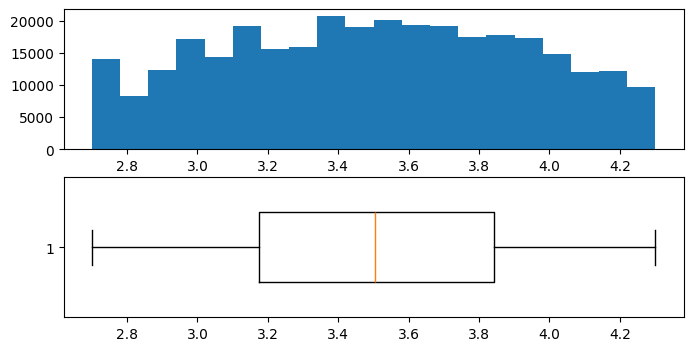

In [58]:
#validemos
fig, ax = plt.subplots(2,1, figsize = [8,4])
ax[0].hist(Z, bins = 20)
ax[1].boxplot(Z,vert=False , widths = 0.5)
plt.show()

### Codificación de atributos no númericos 

In [59]:
F1 = pd.get_dummies(F, drop_first = True, dtype = int)

### Partición de datos

In [60]:
X_train, X_test, Y_train, Y_test = train_test_split(F1, Z, test_size= 0.25, random_state = 123)

### Escalamiento de atributos numéricos

In [61]:
numeric = ['RegistrationYear','Power','Mileage']
scaler = StandardScaler().fit(X_train[numeric])
X_train[numeric] = scaler.transform(X_train[numeric])
X_test[numeric] = scaler.transform(X_test[numeric])


In [62]:
# Validemos
X_train.sample(10)

,RegistrationYear,Power,Mileage,VehicleType_convertible,VehicleType_coupe,VehicleType_other,VehicleType_sedan,VehicleType_small,VehicleType_suv,VehicleType_unknown,...,Brand_smart,Brand_sonstige_autos,Brand_subaru,Brand_suzuki,Brand_toyota,Brand_trabant,Brand_volkswagen,Brand_volvo,NotRepaired_unknown,NotRepaired_yes
329808,-0.070553,-0.980794,0.590781,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
311277,-0.070553,0.092143,0.590781,0,0,0,0,0,1,0,...,0,0,0,1,0,0,0,0,0,0
165181,-0.351322,-0.474692,0.590781,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,0
304809,-0.912859,0.942394,0.590781,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
313069,-1.895548,-0.980794,-0.081314,0,0,0,0,1,0,0,...,0,0,0,0,0,0,1,0,0,0
62401,0.210215,-0.474692,-0.081314,0,0,0,0,0,0,0,...,0,0,0,0,0,0,1,0,0,0
84588,0.069831,-0.980794,-0.753409,0,0,0,0,1,0,0,...,0,0,0,0,0,0,0,0,0,1
6185,-2.316701,-0.980794,0.590781,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,0,0,0
88957,0.210215,-0.575912,-0.753409,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
244458,-0.491706,-0.474692,0.590781,0,0,0,0,0,0,1,...,0,0,0,0,0,0,0,0,1,0


# Modelo de regresión lineal 

In [63]:
#Creamos nuestro modelo y entrenamos
tiempo_inicio = time.time()

reg_mod = LinearRegression(fit_intercept = True)
reg_mod.fit(X_train,Y_train)

tiempo_fin = time.time()

tiempo_total = tiempo_fin - tiempo_inicio
print(f'tiempo de ejecución: {tiempo_total}')


tiempo de ejecución: 4.187541723251343


In [64]:
vrb = list(reg_mod.feature_names_in_)
vrb.append('intercept')

coef = list(reg_mod.coef_)
coef.append(reg_mod.intercept_)

reg_tab = pd.DataFrame(dict(coeficientes = coef), index = vrb)

print(reg_tab)

                         coeficientes
RegistrationYear             0.164338
Power                        0.119748
Mileage                     -0.120845
VehicleType_convertible      0.169326
VehicleType_coupe            0.061072
...                               ...
Brand_volkswagen             0.092039
Brand_volvo                  0.040052
NotRepaired_unknown         -0.078566
NotRepaired_yes             -0.235898
intercept                    3.615694

[312 rows x 1 columns]


In [65]:
#predecimos y evaluamos
y_pred = reg_mod.predict(X_test)
rmse_lin = mean_squared_error(Y_test, y_pred) ** 0.5
rmse_lin

0.2425708349316037

Text(0.5, 1.0, 'Regresión Lineal')

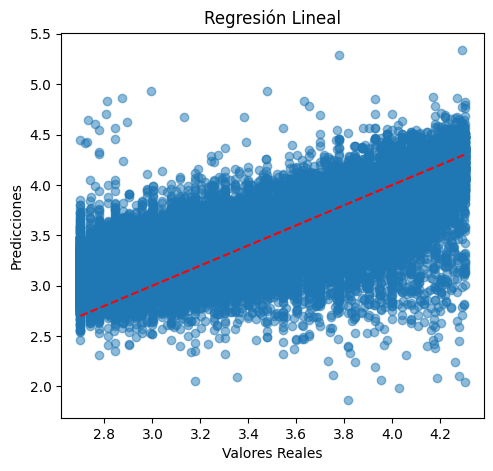

In [66]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal')

In [67]:
lin_r2 = r2_score(Y_test, y_pred)
lin_r2

0.6651451802554144

## Arbol de desiciones 


In [68]:
best_depth = 0
best_rmse= 1000

for depth in range(1,100,5): #Probamos un rago de 1,100
    de_tree = DecisionTreeRegressor(random_state=123 , max_depth= depth) #Definimos nuestro modelo
    de_tree.fit(X_train,Y_train) #Entrenamos 
    pred_dec = de_tree.predict(X_train) #Predecimos
    rmse_dec_tree = mean_squared_error(Y_train,pred_dec) ** 0.5 #calculamos el RMSE
    print(f'max_depth:{depth} , rmse: {rmse_dec_tree}')
    if rmse_dec_tree < best_rmse: 
        best_rmse= rmse_dec_tree #Guardamos el mejor resultado
        best_depth = depth #Guardamos el mejor resultado

print(f"RMSE del mejor modelo en el conjunto de validación (max_depth = {best_depth}): {best_rmse}")

max_depth:1 , rmse: 0.3413441004040692
max_depth:6 , rmse: 0.2312211325356923
max_depth:11 , rmse: 0.19303127550808322
max_depth:16 , rmse: 0.16213178198878675
max_depth:21 , rmse: 0.13594492254717402
max_depth:26 , rmse: 0.11753367713260471
max_depth:31 , rmse: 0.1057028379437849
max_depth:36 , rmse: 0.09889945101047387
max_depth:41 , rmse: 0.09513678311150332
max_depth:46 , rmse: 0.09324822361408776
max_depth:51 , rmse: 0.09240614616274145
max_depth:56 , rmse: 0.09211444416677006
max_depth:61 , rmse: 0.09197758677871096
max_depth:66 , rmse: 0.09191023993387609
max_depth:71 , rmse: 0.09188987005195903
max_depth:76 , rmse: 0.09188927300757153
max_depth:81 , rmse: 0.09188927300757153
max_depth:86 , rmse: 0.09188927300757153
max_depth:91 , rmse: 0.09188927300757153
max_depth:96 , rmse: 0.09188927300757153
RMSE del mejor modelo en el conjunto de validación (max_depth = 76): 0.09188927300757153


In [69]:
#Utilicemos nuestro modelo con datos de validación

ini_tim = time.time()

ar_d = DecisionTreeRegressor(random_state=123, max_depth=51) #usamos los mejores hiperparametros
ar_d.fit(X_train,Y_train)  # Entrenamos

tim_fin = time.time()
tim_tot = tim_fin - ini_tim

ar_pred = ar_d.predict(X_test)
rmse_ar = np.sqrt(mean_squared_error(Y_test,ar_pred)) #Evaluamos

print("\nÀrbol de Decisión:")
print(f"RMSE: {rmse_ar:.4f}")
print(f'Tiempo de entranamiento:{tim_tot}' )


Àrbol de Decisión:
RMSE: 0.1975
Tiempo de entranamiento:3.769382953643799


## Bosque Aleatorio 

In [70]:
#Entrenemos nuestro modelo 
bst_err = 1000
bst_est = 0
bst_depth = 0 

#Queremos encontrar los mejores hiperparametros, lo hacemos con nuestros datos de prueba 
for e in range(1,50,10):
    for d in range(1,30,5):
        rand_forr= RandomForestRegressor(random_state=123, max_depth=d, n_estimators=e)
        rand_forr.fit(X_train,Y_train)
        rand_for_pred = rand_forr.predict(X_train) 
        rmse_rand_for = mean_squared_error(Y_train, rand_for_pred) ** 0.5
        print(F'n_estimator: {e} ,Profundidad {d}, RMSE: {rmse_rand_for}')
        if rmse_rand_for < bst_err:
            bst_err = rmse_rand_for
            bst_est = e
            bst_depth = d
        
print(f"RMSE del mejor modelo en el conjunto de validación (max_depth = {bst_depth}): {bst_err}, n_estimador: {bst_est}")

n_estimator: 1 ,Profundidad 1, RMSE: 0.3413461798819823
n_estimator: 1 ,Profundidad 6, RMSE: 0.23162181779741783
n_estimator: 1 ,Profundidad 11, RMSE: 0.1958608410340802
n_estimator: 1 ,Profundidad 16, RMSE: 0.17301378309799068
n_estimator: 1 ,Profundidad 21, RMSE: 0.15867707918849444
n_estimator: 1 ,Profundidad 26, RMSE: 0.15108618575073768
n_estimator: 11 ,Profundidad 1, RMSE: 0.3413442546965567
n_estimator: 11 ,Profundidad 6, RMSE: 0.2291050786638201
n_estimator: 11 ,Profundidad 11, RMSE: 0.18780690349621643
n_estimator: 11 ,Profundidad 16, RMSE: 0.15646195724307593
n_estimator: 11 ,Profundidad 21, RMSE: 0.13371393248816205
n_estimator: 11 ,Profundidad 26, RMSE: 0.11981154890339149
n_estimator: 21 ,Profundidad 1, RMSE: 0.341344127481485
n_estimator: 21 ,Profundidad 6, RMSE: 0.22695262959794452
n_estimator: 21 ,Profundidad 11, RMSE: 0.18655329697061865
n_estimator: 21 ,Profundidad 16, RMSE: 0.15506390787897575
n_estimator: 21 ,Profundidad 21, RMSE: 0.1321147438985496
n_estimator: 21 

In [71]:
#Utilicemos nuestro modelo con datos de validación
tim_in = time.time()

bos_al = RandomForestRegressor(random_state=123, max_depth=26 , n_estimators=21)
bos_al.fit(X_train,Y_train)

tim_out = time.time()
to_tim = tim_out - tim_in

bos_al_pred = bos_al.predict(X_test)
rmse_bos_al = np.sqrt(mean_squared_error(Y_test, bos_al_pred))

print("\nBosque Aleatorio:")
print(f"RMSE: {rmse_bos_al:.4f}")
print(f'Tiempo de entrenamiento: {to_tim}')


Bosque Aleatorio:
RMSE: 0.1680
Tiempo de entrenamiento: 45.6310830116272


## Potenciación de Gradiente con LightGBM

In [72]:
#Creemos nuestro conjunto de datos 
lgb_train = lgb.Dataset(X_train, Y_train)
lgb_eval = lgb.Dataset(X_test, Y_test, reference=lgb_train)

# Parámetros para LightGBM
params = {
    'boosting_type': 'gbdt',  # Tipo de boosting: gradient boosting decision tree
    'objective': 'regression',  # Objetivo: regresión
    'metric': 'rmse',  # Métrica: raiz del error cuadrático medio
    'num_leaves': 50,  # Número máximo de hojas en cada árbol
    'learning_rate': 0.05,  # Tasa de aprendizaje
    'feature_fraction': 0.9,  # Porcentaje de características a considerar en cada iteración
    'verbose': 0  # Mostrar mensajes cada 100 iteraciones
}

In [73]:
# Entrenar el modelo
in_time = time.time()

gbm = lgb.train(
    params,
    lgb_train,
    num_boost_round=500,  # Número de árboles (iteraciones)
    valid_sets=[lgb_train, lgb_eval],
    callbacks=[lgb.early_stopping(stopping_rounds=50)]  # Detener si no hay mejora en 50 rondas
)

out_time = time.time()
r_time = out_time - in_time

# Predicciones
lgb_pred = gbm.predict(X_test, num_iteration=gbm.best_iteration)
lgb_rmse = np.sqrt(mean_squared_error(Y_test, lgb_pred))

print(f"LightGBM - RMSE: {lgb_rmse:.4f}")
print(f'Tiempo de entrenamiento: {r_time}')

Training until validation scores don't improve for 50 rounds
Did not meet early stopping. Best iteration is:
[500]	training's rmse: 0.161302	valid_1's rmse: 0.166126
LightGBM - RMSE: 0.1661
Tiempo de entrenamiento: 10.055816888809204


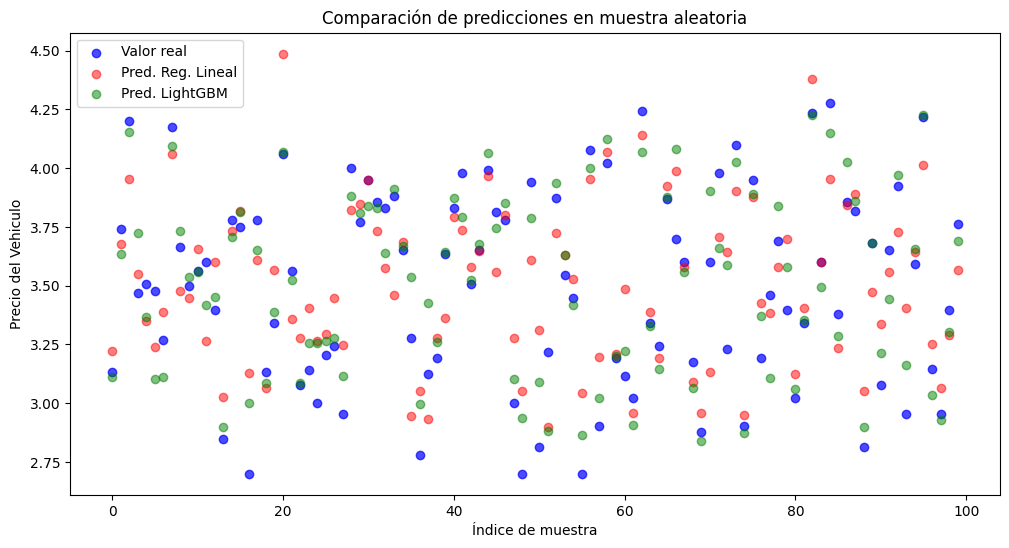

In [74]:
plt.figure(figsize=(12, 6))
# Mostrar solo una muestra para mejor visualización
sample_size = 100
indices = np.random.choice(range(len(Y_test)), sample_size, replace=False)

plt.scatter(range(sample_size), Y_test.iloc[indices], label='Valor real', color='blue', alpha=0.7)
plt.scatter(range(sample_size), y_pred[indices], label='Pred. Reg. Lineal', color='red', alpha=0.5)
plt.scatter(range(sample_size), lgb_pred[indices], label='Pred. LightGBM', color='green', alpha=0.5)
plt.title('Comparación de predicciones en muestra aleatoria')
plt.xlabel('Índice de muestra')
plt.ylabel('Precio del Vehiculo')
plt.legend()
plt.show()

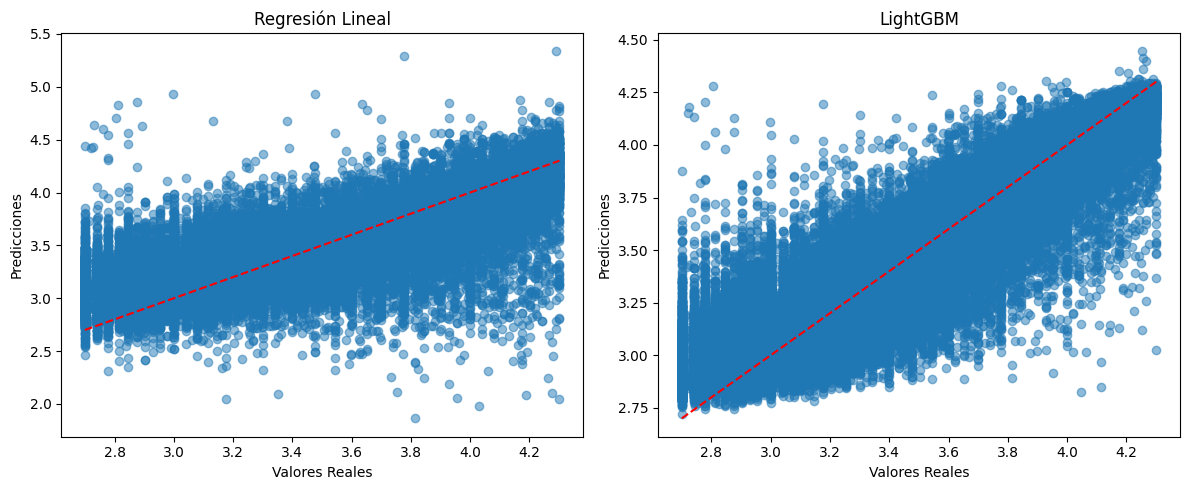

In [75]:
# Visualizamos predicciones vs valores reales para nuestro potenciador 
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal')

plt.subplot(1, 2, 2)
plt.scatter(Y_test, lgb_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('LightGBM')
plt.tight_layout()
plt.show()

## Potenciación de gradiente con Catboost

In [76]:
# Entrenamos un modelo CatBoost
cb_model = CatBoostRegressor(
    iterations=500,           # Número de árboles
    learning_rate=0.05,        # Tasa de aprendizaje
    depth=12,                  # Profundidad máxima de los árboles
    loss_function='RMSE',     # Función de pérdida
    verbose=100,              # Mostrar progreso cada 100 iteraciones
    random_seed=42            # Semilla para reproducibilidad
)
time_in = time.time()

cb_model.fit(X_train, Y_train)

time_out = time.time()
cat_time = time_out - time_in

cb_pred = cb_model.predict(X_test) #Predecimos 

# Evaluamos el modelo
print("\nCatBoost:")
print(f"RMSE: {np.sqrt(mean_squared_error(Y_test, cb_pred)):.4f}")
print(f'Tiempo de entrenamiento: {cat_time}')

0:	learn: 0.4061220	total: 109ms	remaining: 54.3s
100:	learn: 0.1789870	total: 3.56s	remaining: 14.1s
200:	learn: 0.1713420	total: 6.94s	remaining: 10.3s
300:	learn: 0.1671503	total: 10.4s	remaining: 6.88s
400:	learn: 0.1641076	total: 13.6s	remaining: 3.36s
499:	learn: 0.1619173	total: 16.7s	remaining: 0us

CatBoost:
RMSE: 0.1669
Tiempo de entrenamiento: 18.35189199447632


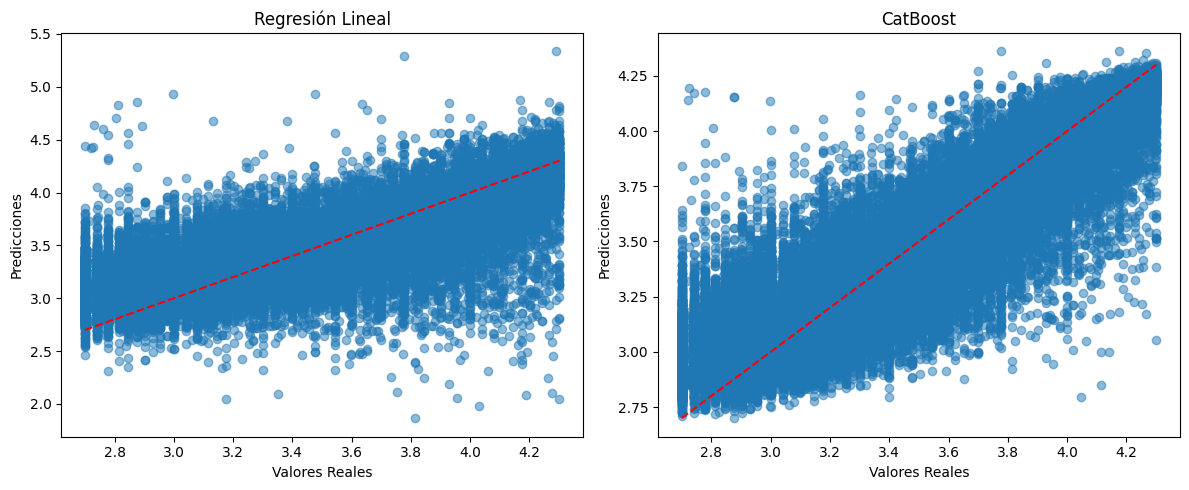

In [77]:
# Visualizamos predicciones vs valores reales
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.scatter(Y_test, y_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('Regresión Lineal')

plt.subplot(1, 2, 2)
plt.scatter(Y_test, cb_pred, alpha=0.5)
plt.plot([Y_test.min(), Y_test.max()], [Y_test.min(), Y_test.max()], 'r--')
plt.xlabel('Valores Reales')
plt.ylabel('Predicciones')
plt.title('CatBoost')
plt.tight_layout()
plt.show()

# Conclusiones 

El dataset tiene muchos valores faltantes e información erronea con picos en extremos 0 o el maximo y sesgados. Lo primero que hicimos fue analizar y determinar la información que vamos a remover. Fijamos un rango de precio ( nuestra variable objetivo) y un rango de años de registro ( 1940 a 2022) con los que vamos a trabajar y removimos todos los datos que estaban fuera de ese rango. 

Reemplazamos los valores dentro de power menores a 60 para tener un minimo real y mayores a 800 para tener un maximo real.

Con los datos limpios corrimos 3 modelos tradicionales: Regresión lineal, árbol de decisiones y bosque aleatorio. Siendo el arbol de desición el mejor modelo ya que tiene un RMSE  bajo(nuestra metrica de evaluación ) y un tiempo de ejecución rapido. . 

Posteriormente realizamos 2 pruebas de descenso de gradiente con un modelo en lightgbm y un modelo en caatboost.

Encontre que el descenso con gradiente usando lightgbm fue el mejor, ya que tuvo un RMSE más bajo y fue más rápido al correrlo. 

Si comparamos el tiempo que toma entrenar a los diferentes modelos probando distintos hiperparámetros. En definitiva el descenso de gradiente con Lightgmb es la mejor opción para este caso. 